*Practical Data Science 21/22*
# Programming Assignment 4 - Cars Classification

In this programming assignment, you will need to apply your new deep learning knowledge on image classification.

First, you need to import all the necessary packages for this assignment.

In [1]:
#!pip install git+https://github.com/fastai/fastai.git # upgrade fastai on colab

In [1]:
from fastai.vision.all import *
from scipy.io import loadmat #this package is used to load matlab files

## Introduction and Dataset

You are provided with the [Cars Dataset](https://ai.stanford.edu/~jkrause/cars/car_dataset.html) by [Krause, Jonathan, et al., 2013](https://www.cv-foundation.org//openaccess/content_iccv_workshops_2013/W19/papers/Krause_3D_Object_Representations_2013_ICCV_paper.pdf). The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.

![Example Car](https://ai.stanford.edu/~jkrause/cars/car4.jpg)

To help you get started, you can use the following code block to download and store the data (this may take a while!)
- You may use the Google Drive [Integration](https://colab.research.google.com/notebooks/io.ipynb) for Google Colab to save and quickly access the data.

In [4]:
!wget 'http://ai.stanford.edu/~jkrause/car196/cars_train.tgz'
!wget 'http://ai.stanford.edu/~jkrause/cars/car_devkit.tgz'
!tar -xf cars_train.tgz && tar -xf car_devkit.tgz

--2021-12-02 08:19:04--  http://ai.stanford.edu/~jkrause/car196/cars_train.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 979269282 (934M) [application/x-gzip]
Saving to: 'cars_train.tgz'

cars_train.tgz      100%[===================>] 933.90M  12.5MB/s    in 81s     

2021-12-02 08:20:26 (11.5 MB/s) - 'cars_train.tgz' saved [979269282/979269282]

--2021-12-02 08:20:26--  http://ai.stanford.edu/~jkrause/car196/cars_annos.mat
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 394471 (385K) [text/plain]
Saving to: 'cars_annos.mat'

cars_annos.mat      100%[===================>] 385.23K   346KB/s    in 1.1s    

2021-12-02 08:20:28 (346 KB/s) - 'cars_annos.mat' saved [394471/394471]

tar: car_ims.tgz

All images of this data set are now stored in the `cars_train` directory. List the first 10 image files in this directory.

In [2]:
# Write your code here
path = 'cars_train'
fnames = get_image_files(path)
fnames[:10]

(#10) [Path('cars_train/06052.jpg'),Path('cars_train/07473.jpg'),Path('cars_train/08033.jpg'),Path('cars_train/00811.jpg'),Path('cars_train/05877.jpg'),Path('cars_train/07505.jpg'),Path('cars_train/00643.jpg'),Path('cars_train/03364.jpg'),Path('cars_train/00442.jpg'),Path('cars_train/05012.jpg')]

Different data sets are labeled in many different ways. The images of this data set are stored in only one directory with their `id` as file name. The labels are stored in a different file called 'cars_annos.mat'. You can use the following code block to load this file into a DataFrame.

In [10]:
# Create Labels from class names
cars_annos = loadmat('devkit/cars_train_annos.mat')
class_names = loadmat('devkit/cars_meta.mat')['class_names']
labels = [c for c in class_names[0]]
labels = pd.DataFrame(labels, columns=['labels'])
labels['class'] = labels.index+1
# Create Data Frame from .mat file
frame = [[i.flat[0] for i in line] for line in cars_annos['annotations'][0]]
columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class','fname']
df = pd.DataFrame(frame, columns=columns)
df['fname'] = path+"/"+df['fname']
df = df.merge(labels, on='class')
df.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname,labels
0,39,116,569,375,14,cars_train/00001.jpg,Audi TTS Coupe 2012
1,39,52,233,150,14,cars_train/00017.jpg,Audi TTS Coupe 2012
2,52,47,586,260,14,cars_train/00411.jpg,Audi TTS Coupe 2012
3,47,92,209,178,14,cars_train/00467.jpg,Audi TTS Coupe 2012
4,7,51,253,156,14,cars_train/00888.jpg,Audi TTS Coupe 2012


## Creating the Dataloaders

Use the [data block API](https://docs.fast.ai/data.block.html#DataBlock) to load the data using `df`

1. Define the blocks
1. Define the `get_x`and `get_y` using the `ColReader()` function (see [docs](https://docs.fast.ai/data.transforms#ColReader) or [example](https://docs.fast.ai/tutorial.vision.html#Multi-label-classification---With-the-data-block-API))
1. Split the images randomly into 85% train and 15% validation set ([docs](https://docs.fast.ai/data.transforms#RandomSplitter), use seed = 42)
1. Define suitable [transforms](https://docs.fast.ai/vision.augment.html#aug_transforms)  

In [11]:
cars = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_x=ColReader('fname'),
                 get_y=ColReader('labels'),
                 splitter=RandomSplitter(valid_pct=0.15, seed=42),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224)
                 )

5. Create the dataloaders from `df`

In [12]:
dls = cars.dataloaders(df)

Now, use the Dataloaders to display three rows of random pictures from a batch.

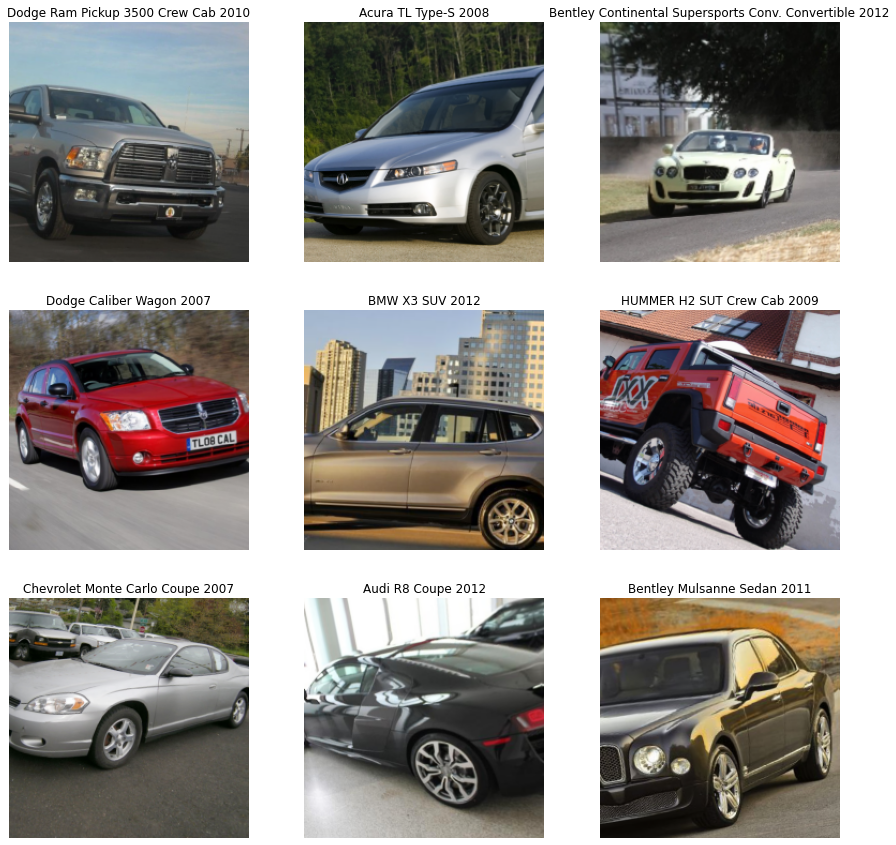

In [14]:
# Write your code here
dls.show_batch(figsize=(15,15))

How many vehicle classes are in the dataset?

__Hint__: use `dls.vocab`

In [18]:
# Write your code here
len(dls.vocab) 

127

## Train the Model

Once the data is ready you can start training a model. Use the `cnn_learner` to create a model with 
- a Resnet34 architecture
- the metrics *accuracy* and [*top-5 accuracy*](https://docs.fast.ai/metrics.html#top_k_accuracy)

In [22]:
# Write your code here
learn = cnn_learner(dls, models.resnet34, metrics=[accuracy, top_k_accuracy])

Finally, you can train the model. Apply the concepts from the lecture, i.e., 
- finding the learning rate
- training the last layers
- unfreezing the model
- train all layers (learning rate rule of thumb!)

Always provide an explanation **why** you chose the number of epochs and the learning rate.

Save the model after each training 
```
learn.save('stage-x')
``` 
so that you can reload the model 
``` 
learn = learn.load('stage-x')
``` 
if something goes wrong. If you load a model with *freezed* layers, you need to *unfreeze* the layers again.

SuggestedLRs(valley=0.0030199517495930195)

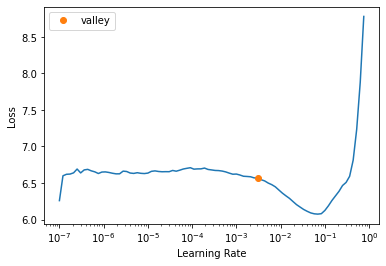

In [20]:
# Write your code and explanations here
learn.lr_find()

In [23]:
# Write your code and explanations here
# Fit the model with the suggested learning rate
learn.fit_one_cycle(10, lr_max=0.003)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,6.031754,4.190085,0.108449,0.254729,00:16
1,4.393240,2.851493,0.287516,0.609079,00:16
2,3.218117,2.248684,0.412358,0.721311,00:16
3,2.411521,1.864182,0.491803,0.795712,00:16
4,1.978946,1.657401,0.552333,0.849937,00:16
5,1.644582,1.472147,0.601513,0.860025,00:16
6,1.353804,1.361685,0.633039,0.886507,00:16
7,1.108137,1.290166,0.640605,0.899117,00:16
8,0.986839,1.249390,0.645649,0.904161,00:16
9,0.915454,1.245507,0.650694,0.904161,00:16


In [24]:
# Write your code and explanations here
learn.save('stage-1')

Path('models/stage-1.pth')

In [25]:
# Write your code and explanations here
# Since our model is working as we expect it to, we will unfreeze our 
# model and train some more.
learn.unfreeze()

In [ ]:
# Write your code and explanations here
# The basic rule of thumb is after you unfreeze (i.e. train the whole thing),
# pass a max learning rate parameter, pass it a slice, make the second 
# part of that slice about 10 times smaller than your first stage.
learn.fit_one_cycle(10, slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


## Result Interpretation






Explain the difference betweeen the metrics *accuracy* and *top_5_accuracy*. Why can it be useful to report both metrics?

In [30]:
# Write your answer here
# Top-1 accuracy is the conventional accuracy: the model answer 
# (the one with highest probability) must be exactly the expected answer.
# Top-5 accuracy means that any of your model 5 highest probability answers 
# must match the expected answer.
# Depending on the problem, both metrics can provide useful insights about 
# the model's performance

Use the [ClassificationInterpretation](https://docs.fast.ai/interpret.html) to analyze the results in more detail. What are your main findings?

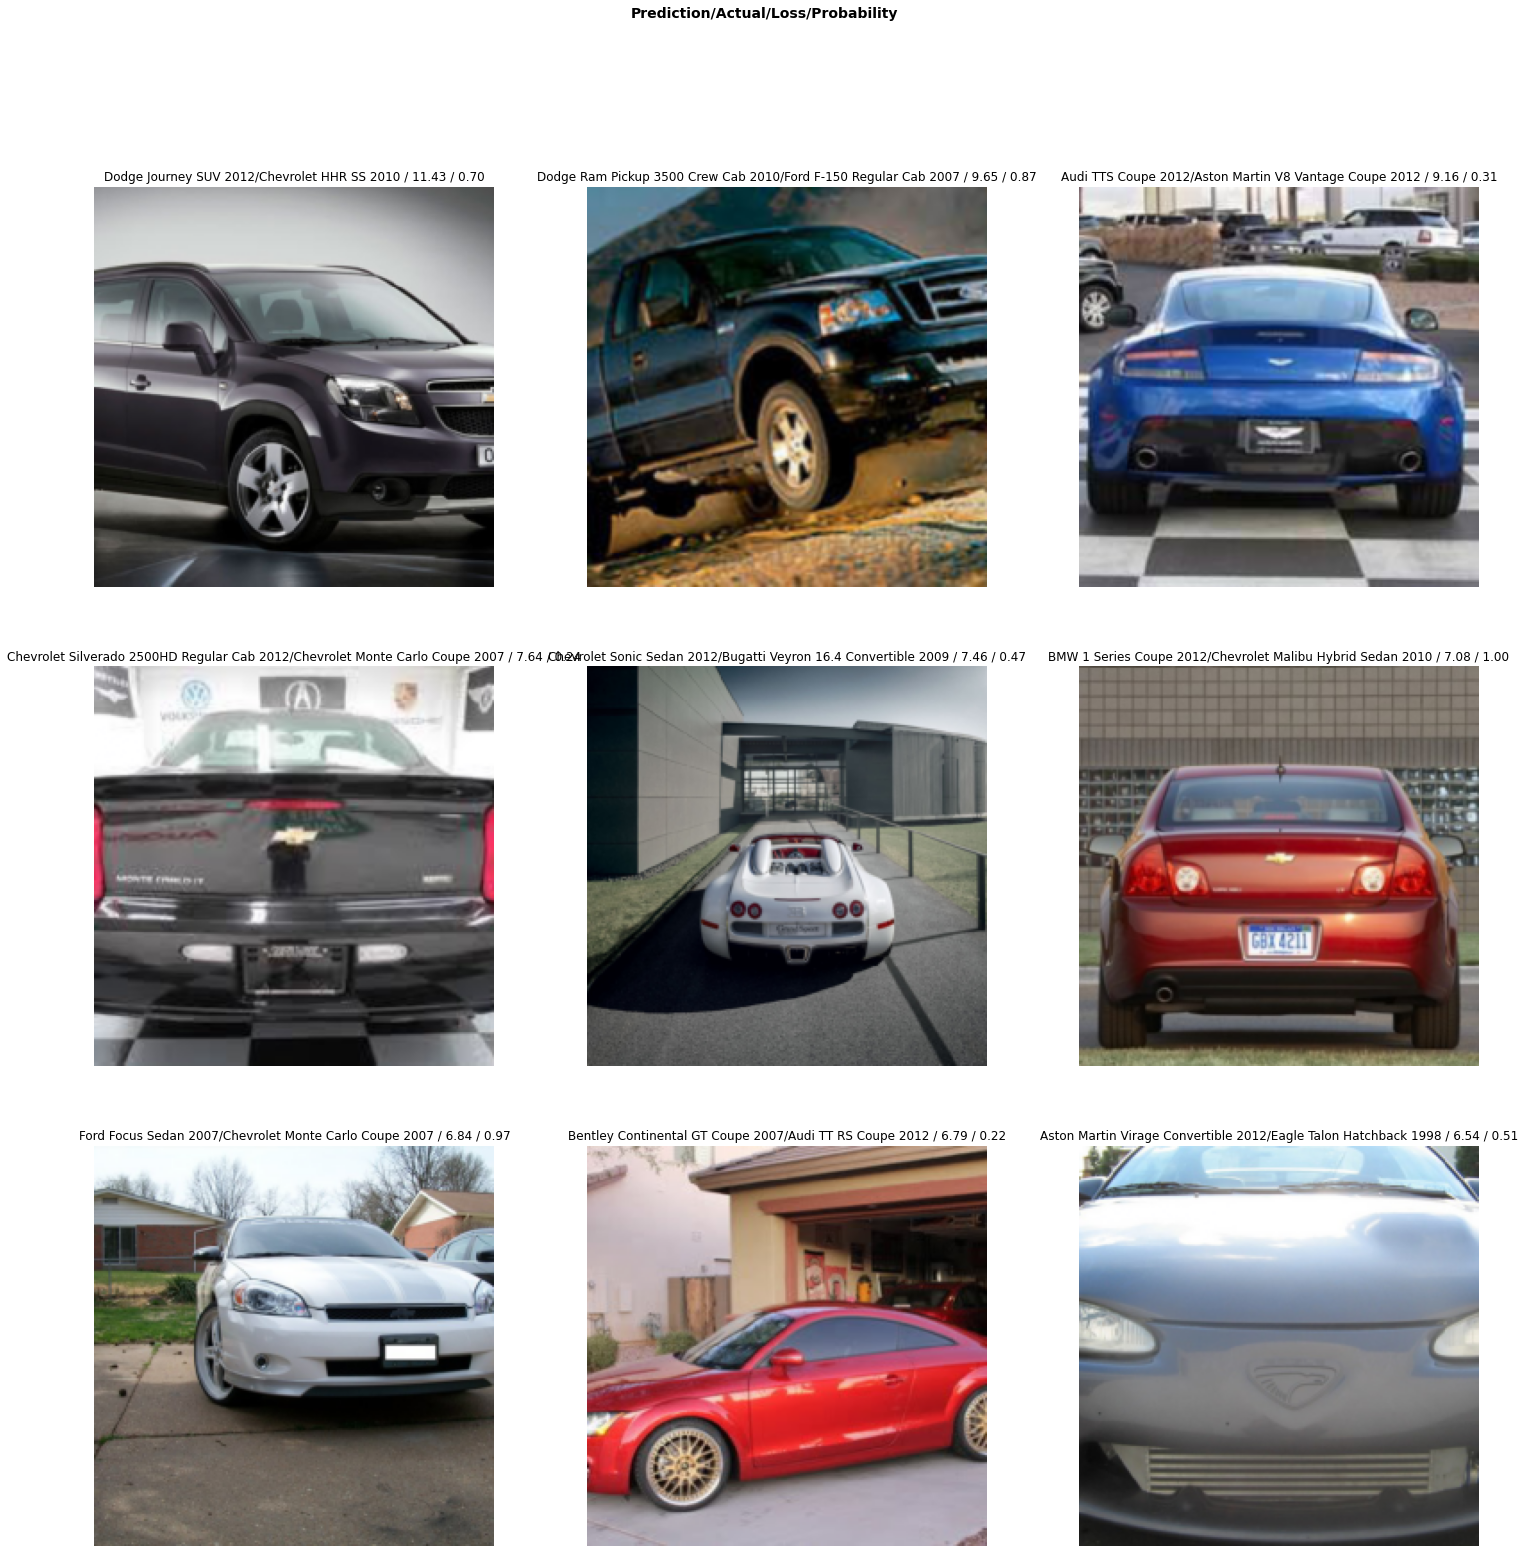

In [31]:
# Write your code and explanations here
# E.g., try explaing the top losses
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(25,25))